In [1]:
import numpy as np
import warnings 
from sklearn.model_selection import train_test_split
import scipy as scio
from scipy.spatial.distance import pdist
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_array, check_random_state
from sklearn.linear_model.ridge import _solve_cholesky_kernel as kernel_solve
from time import time

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

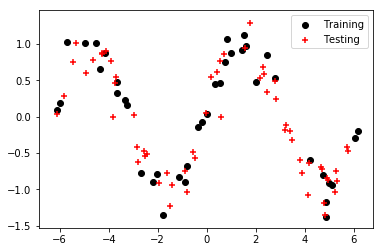

In [4]:
# generate datasets
random_state = 123
num_points = 1000

x_data = np.linspace(-2*np.pi, 2*np.pi, num=num_points)
y_data = np.sin(x_data)

# add some noise
generator = check_random_state(random_state)
y_data += 0.2 * generator.randn(num_points)

# convert to 2D, float array for scikit-learn input
x_data = x_data[:, np.newaxis].astype(np.float)
y_data = y_data[:, np.newaxis].astype(np.float)


# split data into training and testing
train_percent = 0.4

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=train_percent,
    random_state=random_state
)

# plot the training data
fig, ax = plt.subplots()

ax.scatter(x_train[::10], y_train[::10], color='k', label='Training')
ax.scatter(x_test[::10], y_test[::10], color='r', marker='+', label='Testing')

ax.legend()
plt.show()

# remove the mean from the training data
y_mean = np.mean(y_train)

y_train -= y_mean
y_test -= y_mean

In [5]:
# parameter heuristics
mean_sigma = np.mean(pdist(x_train, metric='euclidean'))
lam = 1e-04

mean_gamma = 1 / (2 * mean_sigma ** 2)

# construct kernel matrices
K_train = rbf_kernel(X=x_train, gamma=mean_gamma)

### Different Solvers

In [6]:
weights = {}
times = {}

In [53]:
# slow method: solve problem
t0 = time()
weights['solver'] = \
    scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), 
                      y_train)
t1 = time() - t0
print('Time taken for solve: {:.4f} secs'.format(t1))

Time taken for solve: 0.0191 secs


In [54]:
# scikit kernel cholesky solver
t0 = time()
weights['scikit_solver'] = kernel_solve(K_train, y_train, lam)
t1 = time() - t0
print('Time taken for scikit-solver: {:.4f} secs'.format(t1))

Time taken for scikit-solver: 0.0117 secs


In [55]:
# cholesky: decomposition: manually
t0 = time()
R = cholesky(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_solver'] = scio.linalg.solve(R, scio.linalg.solve(R.T, y_train))
t1 = time() - t0
print('Time taken for cholesky manually: {:.4f} secs'.format(t1))

Time taken for cholesky manually: 0.0219 secs


In [56]:
# cholesky decomposition: with functions
t0 = time()
R, lower = cho_factor(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_factor'] = cho_solve((R, lower), y_train)
t1 = time() - t0
print('\nTime taken for cholesky with functions: {:.4f} secs\n'.format(t1))


Time taken for cholesky with functions: 0.0066 secs



#### Are they the same?

In [57]:
print('Scikit Solver: {}'.format(
    np.allclose(weights['scikit_solver'],
                weights['solver'])))

print('Cholesky Solver: {}'.format(
    np.allclose(weights['chol_solver'],
                weights['solver'])))

print('Cholesky Factor: {}'.format(
    np.allclose(weights['chol_factor'],
                weights['solver'])))

Scikit Solver: True
Cholesky Solver: True
Cholesky Factor: True


#### Are they faster?

In [58]:
solver_time = %timeit -o scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), y_train)
scikit_time = %timeit -o kernel_solve(K_train, y_train, lam)

8.3 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.86 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
%%timeit

# Cholesky Manual Solve
R = cholesky(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_solver'] = scio.linalg.solve(R, scio.linalg.solve(R.T, y_train))
t1 = time() - t0

21.7 ms ± 6.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
%%timeit

# Cholesky Factor Solve
R, lower = cho_factor(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_factor'] = cho_solve((R, lower), y_train)

3.89 ms ± 606 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Predictions (Normal)


In [61]:
%%timeit

# calculate the kernel test matrix
K_test = rbf_kernel(X=x_test, gamma=mean_gamma)

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

# calculate the train-test Kernel matrix
K_traintest = rbf_kernel(x_train, x_test, gamma=mean_gamma)

# calculate the predictions
y_pred = K_traintest.T @ weights['solver']

# calculate the variance
y_var = np.diag(K_test) - np.diag(K_traintest.T @ K_train_inv @ K_traintest)

23.4 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Predictions (Batch)

In [42]:
# split testing data (K-fold)
n_samples, n_dimensions = x_test.shape
n_samples_per_batch = 100
n_batches = int(np.round(n_samples / n_samples_per_batch))

print("Number of Test samples: ", n_samples)
print("Number of samples per batch: ", n_samples_per_batch)
print("Number of batches: {}".format(n_batches))

Number of Test samples:  6000
Number of samples per batch:  100
Number of batches: 60


In [43]:
%%timeit

# Create Batch Iterator Object
BatchIterator = KFold(n_splits=n_batches)

# predefine matrices
y_pred = np.empty(y_test.shape)
variance = np.empty(y_test.shape) 

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

for (ibatch, (_, ibatch_index)) in enumerate(BatchIterator.split(x_test)):
    
    # calculate the train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[ibatch_index], 
                             gamma=mean_gamma)
    
    # calculate the predictions
    y_pred[ibatch_index] = K_traintest.T @ weights['solver']
    
    # calculate the variance
    K_batch = rbf_kernel(x_test[ibatch_index], gamma=mean_gamma)
    
    variance[ibatch_index, 0] = np.diag(K_batch) - \
        np.diag(K_traintest.T @ K_train_inv @ K_traintest)

6.9 s ± 349 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
BatchIterator = KFold(n_splits=n_batches)

# predefine matrices
y_pred = np.empty(y_test.shape)
variance = np.empty(y_test.shape) 

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

for (ibatch, (_, ibatch_index)) in enumerate(BatchIterator.split(x_test)):
    
    # calculate the train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[ibatch_index], 
                             gamma=mean_gamma)
    
    # calculate the predictions
    y_pred[ibatch_index] = K_traintest.T @ weights['solver']
    
    # calculate the variance
    K_batch = rbf_kernel(x_test[ibatch_index], gamma=mean_gamma)
    
    variance[ibatch_index, 0] = np.diag(K_batch) - \
        np.diag(K_traintest.T @ K_train_inv @ K_traintest)

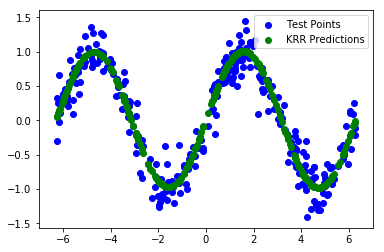

In [45]:
fig, ax = plt.subplots()

ax.scatter(x_test[::20], y_test[::20], color='b', label='Test Points')
ax.scatter(x_test[::20], y_pred[::20], color='g', label='KRR Predictions')


ax.legend()
plt.show()

### Batch Predictions in Parallel

In [46]:
import multiprocessing as mp

In [63]:
# define output queue
output = mp.Queue



In [112]:
#Preliminary Stuff

n_batches = 20
print('Number of batches: {}'.format(n_batches))

# Create Batch Iterator Object
BatchIterator = KFold(n_splits=n_batches)

batch_list = []

for _, ibatch in BatchIterator.split(x_train):
    batch_list.append(ibatch)

# predefine matrices
y_pred = np.empty(y_test.shape)
variance = np.empty(y_test.shape) 

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

def calculate_predictions(ibatch, batch_indices, x_train, x_test, weights, gamma):
    
    test_indices = batch_indices[ibatch]
    K = rbf_kernel(x_train, x_test[test_indices], gamma)
    
    print(K.shape)
    print(weights.shape)
    predictions = K.T @ weights
    return predictions


for _, ibatch in BatchIterator.split(x_train):
    
    K = rbf_kernel(x_train, x_test[ibatch], mean_gamma)


Number of batches: 20


In [114]:
print(weights)

{'chol_factor': array([[  803.39693573],
       [ 2045.41562975],
       [-1962.73641967],
       [ -425.38100788],
       [-1881.41202841],
       [ 3819.6097671 ],
       [-2584.65325663],
       [ 2738.70618266],
       [-1049.54117362],
       [ 2586.35378913],
       [ 3017.24805342],
       [-4439.44193472],
       [ 3589.24207065],
       [  401.80188136],
       [ 1913.44021165],
       [ -247.31735936],
       [  921.61586338],
       [-2890.40901663],
       [ -403.91414663],
       [ 3293.94824293],
       [ 1247.47716757],
       [ 2342.05438667],
       [-5108.81734766],
       [ -476.25903661],
       [-2530.60723033],
       [-3218.68073225],
       [ 1349.61567241],
       [-1496.50491974],
       [-1343.02831713],
       [ 1210.92680363],
       [  779.75677426],
       [  120.7542666 ],
       [  251.43845464],
       [  999.12854055],
       [-1914.50580359],
       [-2590.93910783],
       [ 1576.83976892],
       [-1529.56719122],
       [-1497.91022468],
       [ 

In [113]:
# serial implementation
start_time = time()

results = []
for ibatch in range(len(batch_list)):
    results.append(calculate_predictions(ibatch,
                                         batch_list,
                                         x_train,
                                         x_train,
                                         weights,
                                         mean_gamma))

(400, 20)


AttributeError: 'dict' object has no attribute 'shape'

In [105]:
Pool = mp.Pool(processes=2)

results = \
    [Pool.apply(calculate_predictions,
                args=(ibatch, 
                      batch_list, 
                      x_train, 
                      x_test, 
                      weights, 
                      mean_gamma)) 
           for _, ibatch in len(batch_list)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
def calculate_predictions(ibatch, batch_indices, x_train, x_test, weights, gamma):
    
    test_indices = batch_indices[ibatch]
    print(len(test_indices))
    print(x_train.shape)
    print(x_test.shape)
    print(x_test[test_indices].shape)
    K = rbf_kernel(x_train, x_test[test_indices], gamma)
    predictions = K.T @ weights
    output.put(predictions)